# 用sklearn封装kares模型 进行超参数搜索

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
print(tf.__version__)
print(sys.version_info)
for module in np, pd ,sklearn, tf, keras:
    print(module.__name__,module.__version__)

2.1.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2.post1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

# print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)


(20640, 8)
(20640,)


In [3]:
from sklearn.model_selection import train_test_split

x_train_all,x_test,y_train_all,y_test=train_test_split(housing.data, housing.target,random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all,y_train_all,random_state=11)

In [4]:
from sklearn.preprocessing import StandardScaler
transfer = StandardScaler()
x_train_scaled = transfer.fit_transform(x_train)
x_test_scaled = transfer.transform(x_test)
x_valid_scaled = transfer.transform(x_valid)

In [14]:
# RandomizedSearchCV实现超参数搜索
# 1、转化为sklearn 的model
# 2、定义参数集合
# 3、搜索参数
def build_model(hidden_layers = 2, layer_size = 73, learning_rate = 0.008):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',input_shape = x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,activation='relu'))
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

# 将keras_model转为sklearn_model，参数为一个函数
sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [15]:
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]
history = sklearn_model.fit(x_train_scaled,y_train,epochs=100,
                  validation_data=(x_valid_scaled,y_valid), 
                  callbacks= callbacks )

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 68us/sample - loss: 0.7522 - val_loss: 0.5504
Epoch 2/100
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5554 - val_loss: 0.4795
Epoch 3/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4378 - val_loss: 0.4308
Epoch 4/100
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4010 - val_loss: 0.4106
Epoch 5/100
11610/11610 [==============================] - 1s 49us/sample - loss: 0.3879 - val_loss: 0.3938
Epoch 6/100
11610/11610 [==============================] - 1s 49us/sample - loss: 0.3770 - val_loss: 0.3851
Epoch 7/100
11610/11610 [==============================] - 1s 48us/sample - loss: 0.3772 - val_loss: 0.3825
Epoch 8/100
11610/11610 [==============================] - 1s 49us/sample - loss: 0.3678 - val_loss: 0.3743
Epoch 9/100
11610/11610 [==============================] - 1s 49us/sample - loss: 0.357

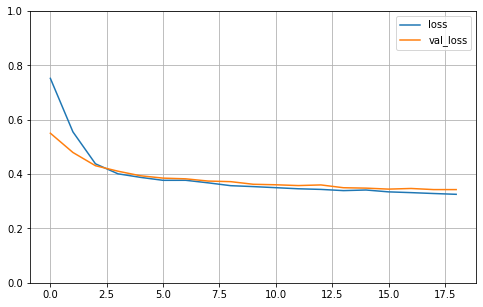

In [16]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=[8,5])
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [17]:
sklearn_model.evaluate(x_test_scaled, y_test)

AttributeError: 'KerasRegressor' object has no attribute 'evaluate'

In [11]:
from scipy.stats import reciprocal# 生成一个区间里连续的分布
param_distribution={
    'hidden_layers': [1,2,3,4],
    'layer_size': np.arange(1,100),
    'learning_rate': reciprocal(1e-4,1e-2)
    }
from sklearn.model_selection import RandomizedSearchCV
estimator = RandomizedSearchCV(sklearn_model, #模型estimator
                                                 param_distribution,#定义好的搜索空间
                                                 n_iter = 10,#要搜索的参数集合数量
                                                 n_jobs = 1#并行处理数据数量
                                                  )

callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]
estimator.fit(x_train_scaled,y_train,epochs=100,
                  validation_data=(x_valid_scaled,y_valid), 
                  callbacks= callbacks)

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 76us/sample - loss: 1.2712 - val_loss: 0.7036
Epoch 2/100
9288/9288 [==============================] - 0s 49us/sample - loss: 0.6464 - val_loss: 0.6359
Epoch 3/100
9288/9288 [==============================] - 0s 49us/sample - loss: 0.5720 - val_loss: 0.5910
Epoch 4/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.5381 - val_loss: 0.5607
Epoch 5/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.5148 - val_loss: 0.5381
Epoch 6/100
9288/9288 [==============================] - 0s 49us/sample - loss: 0.4971 - val_loss: 0.5173
Epoch 7/100
9288/9288 [==============================] - 0s 49us/sample - loss: 0.4838 - val_loss: 0.5037
Epoch 8/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.4709 - val_loss: 0.4878
Epoch 9/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.4592 - val_loss: 0.479

9288/9288 [==============================] - 0s 50us/sample - loss: 0.4954 - val_loss: 0.5221
Epoch 7/100
9288/9288 [==============================] - 0s 49us/sample - loss: 0.4793 - val_loss: 0.5072
Epoch 8/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.4668 - val_loss: 0.4889
Epoch 9/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.4559 - val_loss: 0.4814
Epoch 10/100
9288/9288 [==============================] - 0s 51us/sample - loss: 0.4468 - val_loss: 0.4700
Epoch 11/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.4382 - val_loss: 0.4612
Epoch 12/100
9288/9288 [==============================] - 0s 51us/sample - loss: 0.4318 - val_loss: 0.4572
Epoch 13/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.4259 - val_loss: 0.4516
Epoch 14/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.4191 - val_loss: 0.4395
Epoch 15/100
9288/9288 [=============================

9288/9288 [==============================] - 1s 55us/sample - loss: 0.4721 - val_loss: 0.4948
Epoch 59/100
9288/9288 [==============================] - 1s 55us/sample - loss: 0.4700 - val_loss: 0.4925
Epoch 60/100
9288/9288 [==============================] - 1s 56us/sample - loss: 0.4679 - val_loss: 0.4902
Epoch 61/100
9288/9288 [==============================] - 1s 56us/sample - loss: 0.4658 - val_loss: 0.4883
Epoch 62/100
9288/9288 [==============================] - 1s 56us/sample - loss: 0.4640 - val_loss: 0.4862
Epoch 63/100
9288/9288 [==============================] - 1s 56us/sample - loss: 0.4621 - val_loss: 0.4842
Epoch 64/100
9288/9288 [==============================] - 1s 55us/sample - loss: 0.4603 - val_loss: 0.4824
Epoch 65/100
9288/9288 [==============================] - 1s 55us/sample - loss: 0.4586 - val_loss: 0.4805
Epoch 66/100
9288/9288 [==============================] - 1s 55us/sample - loss: 0.4570 - val_loss: 0.4787
Epoch 67/100
2322/2322 [==========================

9288/9288 [==============================] - 0s 52us/sample - loss: 0.7106 - val_loss: 0.7650
Epoch 12/100
9288/9288 [==============================] - 1s 54us/sample - loss: 0.6930 - val_loss: 0.7495
Epoch 13/100
9288/9288 [==============================] - 1s 55us/sample - loss: 0.6793 - val_loss: 0.7368
Epoch 14/100
9288/9288 [==============================] - 1s 55us/sample - loss: 0.6679 - val_loss: 0.7252
Epoch 15/100
9288/9288 [==============================] - 1s 54us/sample - loss: 0.6582 - val_loss: 0.7159
Epoch 16/100
9288/9288 [==============================] - 1s 55us/sample - loss: 0.6497 - val_loss: 0.7076
Epoch 17/100
9288/9288 [==============================] - 1s 55us/sample - loss: 0.6421 - val_loss: 0.6997
Epoch 18/100
9288/9288 [==============================] - 1s 55us/sample - loss: 0.6350 - val_loss: 0.6926
Epoch 19/100
9288/9288 [==============================] - 1s 55us/sample - loss: 0.6282 - val_loss: 0.6857
Epoch 20/100
9288/9288 [==========================

2322/2322 [==============================] - 0s 26us/sample - loss: 0.3947
Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 105us/sample - loss: 1.9195 - val_loss: 1.3500
Epoch 2/100
9288/9288 [==============================] - 0s 51us/sample - loss: 1.1725 - val_loss: 1.0826
Epoch 3/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.8492 - val_loss: 0.7299
Epoch 4/100
9288/9288 [==============================] - 0s 51us/sample - loss: 0.6125 - val_loss: 0.5922
Epoch 5/100
9288/9288 [==============================] - 0s 51us/sample - loss: 0.5378 - val_loss: 0.5476
Epoch 6/100
9288/9288 [==============================] - 0s 51us/sample - loss: 0.4978 - val_loss: 0.5065
Epoch 7/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.4634 - val_loss: 0.4808
Epoch 8/100
9288/9288 [==============================] - 0s 51us/sample - loss: 0.4403 - val_loss: 0.4540
Epoch 9/100
9288/9288 [=====

9288/9288 [==============================] - 0s 52us/sample - loss: 0.4350 - val_loss: 0.4496
Epoch 9/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.4207 - val_loss: 0.4279
Epoch 10/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.4093 - val_loss: 0.4187
Epoch 11/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.4000 - val_loss: 0.4079
Epoch 12/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.3923 - val_loss: 0.4034
Epoch 13/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.3868 - val_loss: 0.3936
Epoch 14/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.3810 - val_loss: 0.3926
Epoch 15/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.3770 - val_loss: 0.3867
Epoch 16/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.3730 - val_loss: 0.3899
Epoch 17/100
9288/9288 [===========================

9288/9288 [==============================] - 0s 53us/sample - loss: 0.4936 - val_loss: 0.5194
Epoch 24/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4879 - val_loss: 0.5132
Epoch 25/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4826 - val_loss: 0.5074
Epoch 26/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4777 - val_loss: 0.5021
Epoch 27/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4732 - val_loss: 0.4973
Epoch 28/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4689 - val_loss: 0.4926
Epoch 29/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4650 - val_loss: 0.4879
Epoch 30/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4613 - val_loss: 0.4839
Epoch 31/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.4578 - val_loss: 0.4800
Epoch 32/100
9288/9288 [==========================

9288/9288 [==============================] - 0s 52us/sample - loss: 0.4536 - val_loss: 0.4929
Epoch 33/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4503 - val_loss: 0.4889
Epoch 34/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.4474 - val_loss: 0.4853
Epoch 35/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4446 - val_loss: 0.4820
Epoch 36/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4419 - val_loss: 0.4787
Epoch 37/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4393 - val_loss: 0.4755
Epoch 38/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4368 - val_loss: 0.4723
Epoch 39/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4345 - val_loss: 0.4699
Epoch 40/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.4322 - val_loss: 0.4672
Epoch 41/100
9288/9288 [==========================

9288/9288 [==============================] - 0s 51us/sample - loss: 0.3686 - val_loss: 0.3827
Epoch 9/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.3619 - val_loss: 0.3754
Epoch 10/100
9288/9288 [==============================] - 0s 51us/sample - loss: 0.3561 - val_loss: 0.3770
Epoch 11/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.3534 - val_loss: 0.3690
Epoch 12/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.3488 - val_loss: 0.3665
Epoch 13/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.3443 - val_loss: 0.3647
Epoch 14/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.3414 - val_loss: 0.3709
Epoch 15/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.3380 - val_loss: 0.3525
Epoch 16/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.3345 - val_loss: 0.3583
Epoch 17/100
9288/9288 [===========================

9288/9288 [==============================] - 0s 51us/sample - loss: 0.7027 - val_loss: 0.7132
Epoch 4/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.6497 - val_loss: 0.6730
Epoch 5/100
9288/9288 [==============================] - 0s 51us/sample - loss: 0.6123 - val_loss: 0.6413
Epoch 6/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.5829 - val_loss: 0.6125
Epoch 7/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.5574 - val_loss: 0.5878
Epoch 8/100
9288/9288 [==============================] - 0s 51us/sample - loss: 0.5346 - val_loss: 0.5656
Epoch 9/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.5143 - val_loss: 0.5426
Epoch 10/100
9288/9288 [==============================] - 0s 51us/sample - loss: 0.4954 - val_loss: 0.5226
Epoch 11/100
9288/9288 [==============================] - 0s 51us/sample - loss: 0.4786 - val_loss: 0.5042
Epoch 12/100
9288/9288 [==============================] 

9288/9288 [==============================] - 0s 50us/sample - loss: 0.5580 - val_loss: 0.5957
Epoch 17/100
9288/9288 [==============================] - 0s 49us/sample - loss: 0.5493 - val_loss: 0.5870
Epoch 18/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.5414 - val_loss: 0.5788
Epoch 19/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.5341 - val_loss: 0.5714
Epoch 20/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.5273 - val_loss: 0.5637
Epoch 21/100
9288/9288 [==============================] - 0s 51us/sample - loss: 0.5210 - val_loss: 0.5574
Epoch 22/100
9288/9288 [==============================] - 0s 49us/sample - loss: 0.5151 - val_loss: 0.5515
Epoch 23/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.5096 - val_loss: 0.5461
Epoch 24/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.5045 - val_loss: 0.5406
Epoch 25/100
9288/9288 [==========================

9288/9288 [==============================] - 0s 50us/sample - loss: 0.4306 - val_loss: 0.4643
Epoch 59/100
2322/2322 [==============================] - 0s 25us/sample - loss: 0.4533
Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 74us/sample - loss: 3.8605 - val_loss: 2.5611
Epoch 2/100
9288/9288 [==============================] - 0s 50us/sample - loss: 1.7836 - val_loss: 1.4921
Epoch 3/100
9288/9288 [==============================] - 0s 51us/sample - loss: 1.1453 - val_loss: 1.0725
Epoch 4/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.8859 - val_loss: 0.8927
Epoch 5/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.7690 - val_loss: 0.8089
Epoch 6/100
9288/9288 [==============================] - 0s 50us/sample - loss: 0.7126 - val_loss: 0.7660
Epoch 7/100
9288/9288 [==============================] - 0s 51us/sample - loss: 0.6839 - val_loss: 0.7417
Epoch 8/100
9288/9288 [=====

9288/9288 [==============================] - 0s 53us/sample - loss: 0.3899 - val_loss: 0.4066
Epoch 20/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.3857 - val_loss: 0.4025
Epoch 21/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.3826 - val_loss: 0.4005
Epoch 22/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.3795 - val_loss: 0.3971
Epoch 23/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.3771 - val_loss: 0.3953
Epoch 24/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.3754 - val_loss: 0.3937
Epoch 25/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.3720 - val_loss: 0.3904
Epoch 26/100
9288/9288 [==============================] - 0s 53us/sample - loss: 0.3702 - val_loss: 0.3881
Epoch 27/100
9288/9288 [==============================] - 0s 52us/sample - loss: 0.3678 - val_loss: 0.3853
Epoch 28/100
2322/2322 [==========================

9288/9288 [==============================] - 1s 57us/sample - loss: 0.5776 - val_loss: 0.6193
Epoch 20/100
9288/9288 [==============================] - 1s 56us/sample - loss: 0.5711 - val_loss: 0.6126
Epoch 21/100
9288/9288 [==============================] - 1s 57us/sample - loss: 0.5648 - val_loss: 0.6068
Epoch 22/100
9288/9288 [==============================] - 1s 56us/sample - loss: 0.5591 - val_loss: 0.6008
Epoch 23/100
9288/9288 [==============================] - 1s 57us/sample - loss: 0.5535 - val_loss: 0.5948
Epoch 24/100
9288/9288 [==============================] - 1s 56us/sample - loss: 0.5480 - val_loss: 0.5891
Epoch 25/100
9288/9288 [==============================] - 1s 56us/sample - loss: 0.5429 - val_loss: 0.5837
Epoch 26/100
9288/9288 [==============================] - 1s 57us/sample - loss: 0.5379 - val_loss: 0.5786
Epoch 27/100
9288/9288 [==============================] - 1s 57us/sample - loss: 0.5332 - val_loss: 0.5736
Epoch 28/100
9288/9288 [==========================

2322/2322 [==============================] - 0s 26us/sample - loss: 0.4441
Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 85us/sample - loss: 3.4185 - val_loss: 2.1766
Epoch 2/100
9288/9288 [==============================] - 1s 56us/sample - loss: 1.5217 - val_loss: 1.2462
Epoch 3/100
9288/9288 [==============================] - 1s 57us/sample - loss: 1.0460 - val_loss: 1.0041
Epoch 4/100
9288/9288 [==============================] - 1s 57us/sample - loss: 0.8807 - val_loss: 0.8964
Epoch 5/100
9288/9288 [==============================] - 1s 57us/sample - loss: 0.7966 - val_loss: 0.8375
Epoch 6/100
9288/9288 [==============================] - 1s 57us/sample - loss: 0.7495 - val_loss: 0.8000
Epoch 7/100
9288/9288 [==============================] - 1s 57us/sample - loss: 0.7193 - val_loss: 0.7745
Epoch 8/100
9288/9288 [==============================] - 1s 58us/sample - loss: 0.6976 - val_loss: 0.7548
Epoch 9/100
9288/9288 [======

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fba5402bc18>, as the constructor either does not set or modifies parameter layer_size

In [ ]:
# reciprocal函数演示
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a))     a<x<b
reciprocal.rvs(1e-4, 1e-2, size =10)
# print(reciprocal(1e-4, 1e-2))#, size =10)

In [12]:
#最佳参数
print('最佳参数：\n',estimator.best_params_)
#最佳结果
print('最佳结果:\n',estimator.best_score_)
#最佳估计器
print('最佳估计器：\n',estimator.best_estimator_)
#交叉验证结果
# print('交叉验证结果:\n',estimator.cv_results_)

最佳参数：
 {'hidden_layers': 2, 'layer_size': 73, 'learning_rate': 0.007999382902609955}
最佳结果:
 -0.33451719889858483


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [13]:
model = estimator.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'